In [1]:
import copy
from core.datasets import FER13
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
from torchsummary import summary
%matplotlib inline

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [2]:
preprocess = {
    'train': transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomCrop(36),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(36),
        transforms.ToTensor(),
    ])
}

In [3]:
datasets = {
    x: FER13(
        root = "./data",
        train = True if x == "train" else False,
        transform = preprocess[x],
        color_mode = True
    )
    for x in ["train", "val"]
}

In [4]:
datasets["train"]

Dataset FER13
    Number of datapoints: 28709
    Root location: ./data
    Split: Train
    Compose(
    RandomRotation(degrees=(-20, 20), resample=False, expand=False)
    RandomCrop(size=(36, 36), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [5]:
datasets["val"]

Dataset FER13
    Number of datapoints: 3589
    Root location: ./data
    Split: Test
    Compose(
    CenterCrop(size=(36, 36))
    ToTensor()
)

In [6]:
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=1024,
        shuffle=False,
        num_workers=4
    )
    for x in ["train", "val"]
}
class_names = datasets["train"].classes
dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "val"]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap=plt.cm.gray)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

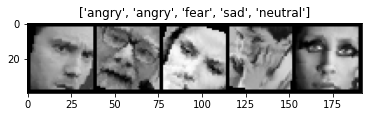

In [8]:
inputs, classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_tracker = {
        'train': [],
        'val': [],
    }

    acc_tracker = {
        'train': [],
        'val': [],
    }

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                labels = labels.type(torch.LongTensor)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_tracker[phase].append(epoch_loss)
            acc_tracker[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        epoch_run_time = time.time() - start
        print(f'epoch running time: {epoch_run_time//60:.03}m {epoch_run_time%60:.03}s')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_tracker, acc_tracker

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
# gray_model = models.vgg16(pretrained=True)
gray_model = torch.load("back_up_wu.pth")
for param in gray_model.parameters():
    param.requires_grad = True

In [12]:
gray_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# gray_model.classifier.requires_grad_(True)
# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = gray_model.classifier[0].in_features
# Alternative
"""
gray_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, len(class_names))
)
"""
# gray_model.fc = nn.Linear(num_ftrs, len(class_names))

'\ngray_model.classifier = nn.Sequential(\n    nn.Linear(num_ftrs, 4096),\n    nn.ReLU(inplace=True),\n    nn.Dropout(0.5),\n    nn.Linear(4096, 4096),\n    nn.ReLU(inplace=True),\n    nn.Dropout(0.5),\n    nn.Linear(4096, len(class_names))\n)\n'

In [14]:
gray_model = gray_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params_to_update = []
for param in gray_model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 50 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=1)

In [15]:
summary(gray_model, (3,36,36))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 36, 36]           1,792
              ReLU-2           [-1, 64, 36, 36]               0
            Conv2d-3           [-1, 64, 36, 36]          36,928
              ReLU-4           [-1, 64, 36, 36]               0
         MaxPool2d-5           [-1, 64, 18, 18]               0
            Conv2d-6          [-1, 128, 18, 18]          73,856
              ReLU-7          [-1, 128, 18, 18]               0
            Conv2d-8          [-1, 128, 18, 18]         147,584
              ReLU-9          [-1, 128, 18, 18]               0
        MaxPool2d-10            [-1, 128, 9, 9]               0
           Conv2d-11            [-1, 256, 9, 9]         295,168
             ReLU-12            [-1, 256, 9, 9]               0
           Conv2d-13            [-1, 256, 9, 9]         590,080
             ReLU-14            [-1, 25

In [16]:
gray_model, losses, accuracies = train_model(
    gray_model,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=100
)

Epoch 0/99
----------
train Loss: 1.6048 Acc: 0.3667
val Loss: 1.5127 Acc: 0.4241
epoch running time: 0.0m 48.3s

Epoch 1/99
----------
train Loss: 1.5570 Acc: 0.3892
val Loss: 1.4842 Acc: 0.4288
epoch running time: 0.0m 48.4s

Epoch 2/99
----------
train Loss: 1.5273 Acc: 0.4070
val Loss: 1.4344 Acc: 0.4452
epoch running time: 0.0m 48.4s

Epoch 3/99
----------
train Loss: 1.4924 Acc: 0.4209
val Loss: 1.3995 Acc: 0.4634
epoch running time: 0.0m 48.6s

Epoch 4/99
----------
train Loss: 1.4669 Acc: 0.4346
val Loss: 1.3764 Acc: 0.4795
epoch running time: 0.0m 48.2s

Epoch 5/99
----------
train Loss: 1.4492 Acc: 0.4405
val Loss: 1.3639 Acc: 0.4823
epoch running time: 0.0m 48.2s

Epoch 6/99
----------
train Loss: 1.4346 Acc: 0.4462
val Loss: 1.3614 Acc: 0.4848
epoch running time: 0.0m 48.6s

Epoch 7/99
----------
train Loss: 1.4217 Acc: 0.4541
val Loss: 1.3566 Acc: 0.4884
epoch running time: 0.0m 48.3s

Epoch 8/99
----------
train Loss: 1.4016 Acc: 0.4602
val Loss: 1.3114 Acc: 0.5040
epoch 

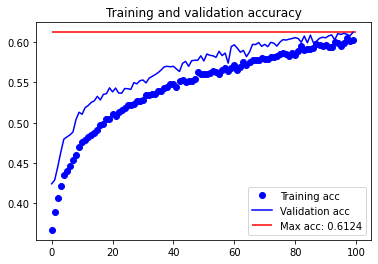

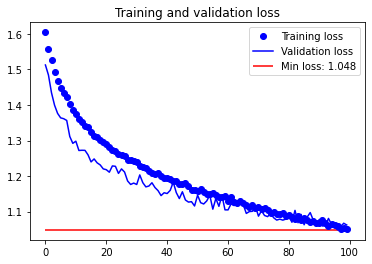

In [17]:
acc = accuracies['train']
val_acc = accuracies['val']
loss = losses['train']
val_loss = losses['val']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.hlines(float(max(val_acc)), xmin=0, xmax=len(acc), colors='r', label=f'Max acc: {float(max(val_acc)):0.04}')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.hlines(float(min(val_loss)), xmin=0, xmax=len(acc), colors='r', label=f'Min loss: {float(min(val_loss)):0.04}')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
torch.save(gray_model, "back_up_ft.pth")